In [43]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

In [ ]:
# following tutorial from amazing statsquest https://www.youtube.com/watch?v=q90UDEgYqeI&ab_channel=StatQuestwithJoshStarmer

In [9]:
# create eval metrics

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
results_df = pd.DataFrame(columns = ['f1','accuracy','precision','recall'])

In [25]:
 # Accuracy, precision, recall, F1
    
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def calc_results_row(y_pred, y_true, model):
    
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    
    row = {'model' : model,
           'f1': f1,
           'accuracy': acc, 
           'precision': prec,
           'recall': recall}
    return row

In [2]:
fish_df = pd.read_csv('D:/Projects/FailSafe_500/3. Fish-market/temp data/Fish.csv')

In [15]:
# split data

X_train, X_test, y_train, y_test = train_test_split(fish_df.drop('Species',axis=1), fish_df.Species, test_size=0.2)

# encode y
le = LabelEncoder()
le.fit(pd.concat([y_train, y_test],axis=0))  
y_train = le.transform(y_train) 
y_test = le.transform(y_test)

# not going to scale features 

In [26]:
# BASELINE
pd.Series(y_train).value_counts()

y_pred = [2]*len(y_test)
y_true = y_test
results_row = calc_results_row(y_pred, y_true, 'Baseline')
results_row

C:\Users\nikig\anaconda3\envs\AutoML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'model': 'Baseline',
 'f1': 0.0911854103343465,
 'accuracy': 0.46875,
 'precision': 0.06696428571428571,
 'recall': 0.14285714285714285}

In [27]:
results_df = results_df.append(results_row, ignore_index=True)
results_df

,f1,accuracy,precision,recall,model
0,0.091185,0.46875,0.066964,0.142857,Baseline


In [8]:
dt_clf = DecisionTreeClassifier() 
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [32]:
y_pred = dt_clf.predict(X_test)
y_true = le.inverse_transform(y_test)
results_row = calc_results_row(y_pred, y_true, 'Decision Tree (default param)')
results_df = results_df.append(results_row, ignore_index=True)
results_df 

,f1,accuracy,precision,recall,model
0,0.091185,0.46875,0.066964,0.142857,Baseline
1,0.969388,0.93750,0.964286,0.980952,Decision Tree (default param)


<Figure size 1080x540 with 0 Axes>

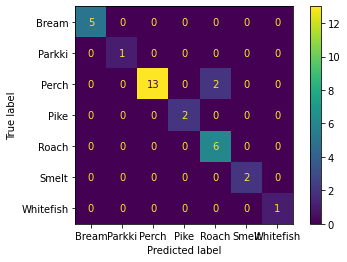

In [45]:
plt.figure(figsize=(15,7.5))
cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()
plt.show() #literally got all of them correct besides for Perch which it labeled as Roach

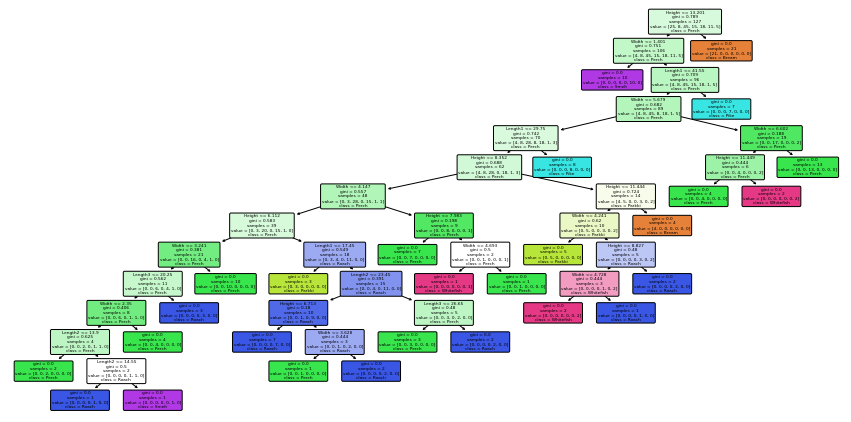

In [47]:
plt.figure(figsize=(15,7.5))
tree.plot_tree(dt_clf, filled=True, rounded=True, feature_names=fish_df.drop(['Species'],axis=1).columns,class_names=le.classes_)
plt.show()

In [48]:
# optimizing tree to maybe get a simpler set of rules 
# not running grid search for now: going by hand

# ccp: cost complexity pruning 
path = dt_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] #exclude max value for alpha 

dt_clf_list = []

for ccp_alpha in ccp_alphas:
    dt_clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dt_clf.fit(X_train,y_train)
    dt_clf_list.append(dt_clf)

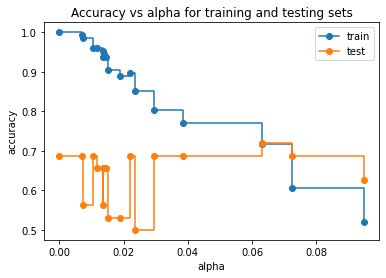

In [50]:
train_scores = [dt_clf.score(X_train,y_train) for dt_clf in dt_clf_list] #difference between .score and .predict?
test_scores = [dt_clf.score(X_test,y_test) for dt_clf in dt_clf_list] 

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

In [ ]:
# from above: we start with highest accuracy from largest tree - no pruning. As we prune more, interestingly, 
# train accuracy goes down but test accuracy oscillates. Maybe its not stable? 
# we probably get the best alpha between 0.06 and 0.07. 0.07 + results in much lower training scores than test scores. 

<AxesSubplot:xlabel='tree'>

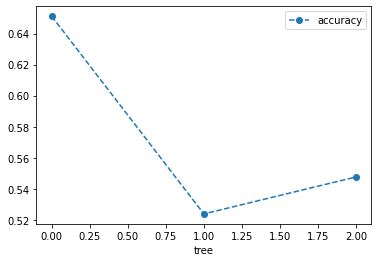

In [52]:
# use cross-validation to verify the ccp parameter eyeballed 

dt_clf = DecisionTreeClassifier(ccp_alpha=0.07)
scores = cross_val_score(dt_clf, X_train, y_train, cv=3)
df = pd.DataFrame(data={'tree':range(3), 'accuracy':scores})
df.plot(x='tree',y='accuracy',marker='o',linestyle='--') #not optimal across every fold

<AxesSubplot:xlabel='alpha'>

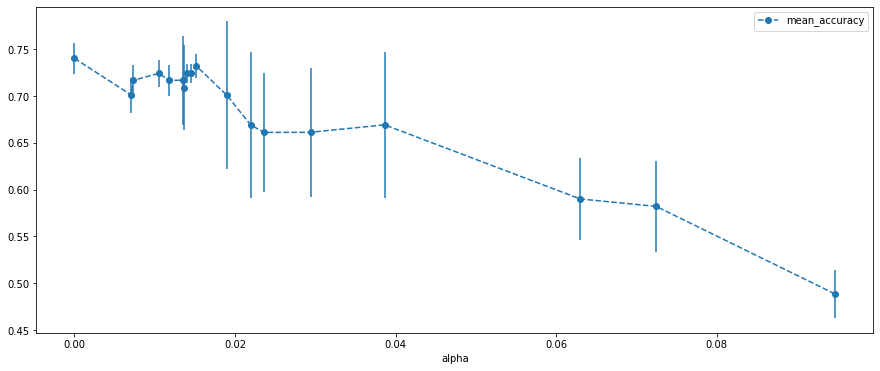

In [59]:
# above shows that alpha is sensitive to the split of data. This is especially true in our case where out data is really tiny. 

# perform cross-validation
alpha_vals=[]
for ccp_alpha in ccp_alphas:
    dt_clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt_clf, X_train, y_train, cv = 3)
    alpha_vals.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results_df = pd.DataFrame(alpha_vals, columns = ['alpha','mean_accuracy','std'])

alpha_results_df.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o', linestyle='--', figsize=(15, 6))

In [60]:
# it seems like smaller alphas are actually better. 
alpha_results_df


,alpha,mean_accuracy,std
0,0.000000,0.740310,0.016801
1,0.007087,0.700997,0.018794
2,0.007268,0.716685,0.016589
3,0.010499,0.724252,0.014095
4,0.011811,0.716685,0.016589
5,0.013498,0.717054,0.047595
6,0.013585,0.709118,0.045358
7,0.013998,0.724437,0.010032
8,0.014537,0.724437,0.010032
9,0.015165,0.732189,0.012901


In [61]:
alpha_best = 0.015165

In [65]:
dt_pruned_clf = DecisionTreeClassifier(ccp_alpha=alpha_best)
dt_pruned_clf.fit(X_train, y_train)

y_pred = dt_pruned_clf.predict(X_test)
y_true = y_test
results_row = calc_results_row(y_pred, y_true, 'Decision Tree (best alpha)')
results_df = results_df.append(results_row, ignore_index=True)
results_df

,f1,accuracy,precision,recall,model
0,0.091185,0.46875,0.066964,0.142857,Baseline
1,0.969388,0.93750,0.964286,0.980952,Decision Tree (default param)
2,0.601648,0.53125,0.606494,0.604762,Decision Tree (best alpha)


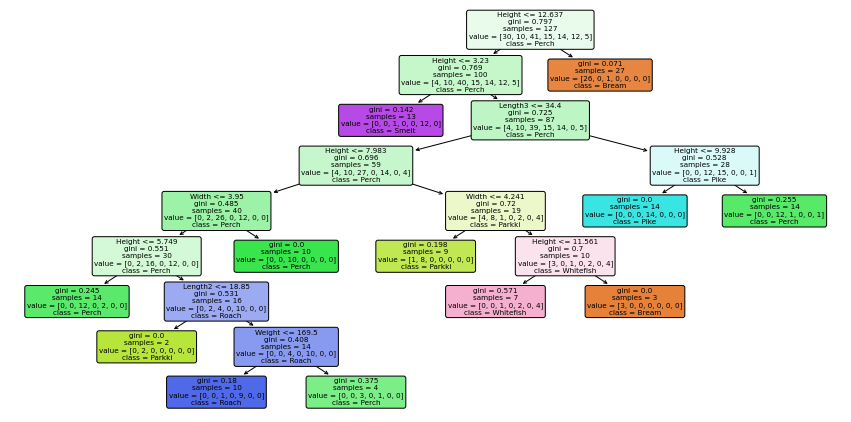

In [66]:
# okay we maybe semi expected that. The tree had learned all the good patterns it was supposed to learn and pruning it means underfitting 

# if however, we are wanting to understand the rules, then the first tree was a bit too complex and this tree is quite a perfect trade-off 
plt.figure(figsize=(15,7.5))
tree.plot_tree(dt_pruned_clf, filled=True, rounded=True, feature_names=fish_df.drop(['Species'],axis=1).columns,class_names=le.classes_)
plt.show()

### how to read the tree:
starting from the top line in a node to the bottom:
1. feature split
2. gini score
3. number of samples in the node
4. value is number of classifications in that node
5. class is majority 

Note: 
- the colour corresponds to majority class. Eg: greens are Perch, pinks are Whitefish and brick is Bream. 
- leaves do not have column names because they are not splitting data


In [67]:
fish_df['Species'].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

In [74]:
dt_clf.decision_path(X_test)

<32x49 sparse matrix of type '<class 'numpy.int64'>'
	with 238 stored elements in Compressed Sparse Row format>

C:\Users\nikig\anaconda3\envs\AutoML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


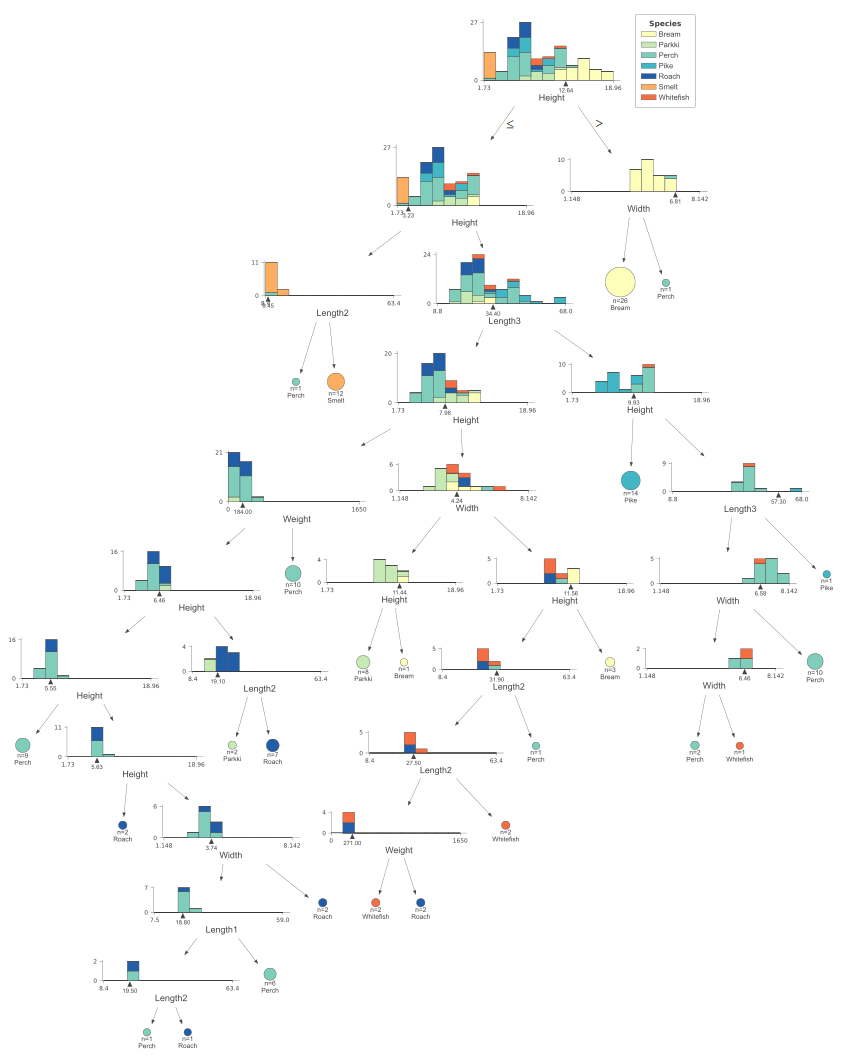

In [77]:
from dtreeviz.trees import dtreeviz 

viz = dtreeviz(dt_clf, X_train, y_train,
                target_name="Species",
                feature_names=fish_df.drop(['Species'],axis=1).columns,
                class_names=list(le.classes_))

viz